Convert CLDCLASS-LIDAR from the layer format saved in the files to a cloud type mask with the same vertical levels as other Cloudsat products

In [1]:
import pathlib
import numpy as np
from numpy import ma
import xarray as xr
import matplotlib.pyplot as plt
from cloudsatipy import open_cloudsat

In [2]:
data_path = pathlib.Path("../data")
data_files = sorted(list(data_path.glob("*2B-CLDCLASS-LIDAR*.hdf")))

In [3]:
data_files

[PosixPath('../data/2010195112321_22399_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E03_F00.hdf')]

In [4]:
ds = open_cloudsat(data_files[0])
ds

<xarray.Dataset> Size: 38MB
Dimensions:                    (Nray: 37081, Nbin: 125, Ncloud: 10)
Coordinates:
    Profile_time               (Nray) datetime64[ns] 297kB 2010-07-14T11:23:2...
    UTC_start                  float64 8B 4.1e+04
    TAI_start                  float64 8B 5.533e+08
    Latitude                   (Nray) float32 148kB -0.001594 ... 0.009657
    Longitude                  (Nray) float32 148kB -144.6 -144.6 ... -169.3
    Height                     (Nray, Nbin) float32 19MB 2.503e+04 ... -4.804...
    Range_to_intercept         (Nray) float32 148kB 705.5 705.5 ... 705.4 705.4
    DEM_elevation              (Nray) float32 148kB nan nan nan ... nan nan nan
    Vertical_binsize           float64 8B 239.8
    Pitch_offset               float64 8B 0.16
    Roll_offset                float64 8B 0.0
Dimensions without coordinates: Nray, Nbin, Ncloud
Data variables: (12/18)
    Data_quality               (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Data_status                (Nray) float32 148kB 4.148e+03 ... 4.148e+03
    Data_targetID              (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RayStatus_validity         (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Navigation_land_sea_flag   (Nray) float32 148kB 2.0 2.0 2.0 ... 2.0 2.0 2.0
    Cloudlayer                 (Nray) float32 148kB 1.0 1.0 1.0 ... 2.0 2.0 2.0
    ...                         ...
    CloudPhase                 (Nray, Ncloud) float32 1MB 3.0 0.0 ... 0.0 0.0
    CloudPhaseConfidenceLevel  (Nray, Ncloud) float32 1MB 10.0 1.0 ... 1.0 1.0
    CloudLayerType             (Nray, Ncloud) float32 1MB 6.0 0.0 ... 0.0 0.0
    CloudTypeQuality           (Nray, Ncloud) float32 1MB 1.0 1.0 ... 1.0 1.0
    Phase_log                  (Nray, Ncloud) float32 1MB 2.0 nan ... nan nan
    Water_layer_top            (Nray, Ncloud) float32 1MB 0.475 nan ... nan nan
Attributes:
    granule_number:     22399.0
    ID_SITE:            Cooperative Institute for Research in the Atmosphere
    ID_CENTER:          CloudSat Data Processing Center
    ID_CENTER_URL:      http://cloudsat.cira.colostate.edu
    ID_MACHINE:         CSATLAS2
    ID_CREATED:         Sun Feb 24 22:57:33 2019
    algorithm_name:     2B-CLDCLASS-LIDAR
    algorithm_version:  P1_R05.0
    product_version:    P1_R05
    start_time:         20100714112321
    end_time:           20100714130213

In [5]:
def construct_cloud_type_mask(cldclass_ds):
    cloud_type_mask = xr.DataArray(
        np.zeros_like(cldclass_ds.Height.values), cldclass_ds.Height.coords, cldclass_ds.Height.dims
    )

    for cloud_layer in cldclass_ds.Ncloud.values:
        if np.any(ds.CloudLayerType[cloud_layer]).item():
            raveled_idx, n_cloud_bins = get_layer_indices(
                cldclass_ds.Height, 
                cldclass_ds.CloudLayerTop[...,cloud_layer], 
                cldclass_ds.CloudLayerBase[...,cloud_layer], 
            )
            cloud_type_mask.data.ravel()[raveled_idx] = np.repeat(
                cldclass_ds.CloudLayerType[...,cloud_layer].values, n_cloud_bins
            )
        else:
            break

    attrs = cldclass_ds.CloudLayerType.attrs.copy()

    attrs["Flag_values"] = ["Deep", "Ns", "Cu", "Sc", "St", "Ac", "As", "High"][::-1]

    cloud_type_mask = cloud_type_mask.assign_attrs(attrs)

    return cloud_type_mask


def find_nearest_height_bins(heights, layer_height):
    return np.nanargmin(
        np.abs(heights - (layer_height.fillna(np.inf)*1e3)).values, axis=1
    )

def get_layer_indices(heights, layer_top, layer_base):
    top_bin = find_nearest_height_bins(heights, layer_top)
    base_bin = find_nearest_height_bins(heights, layer_base)
    
    n_cloud_bins = base_bin - top_bin + 1

    nbin_idx = np.repeat(top_bin, n_cloud_bins) + repeat_ranges(n_cloud_bins)
    nray_idx = np.repeat(heights.Nray.values, n_cloud_bins)

    raveled_idx = np.ravel_multi_index([nray_idx.astype(int), nbin_idx.astype(int)], heights.shape)
    
    return raveled_idx, n_cloud_bins

def repeat_ranges(n_repeats):
    repeat_range = np.repeat(np.ones(n_repeats.size), n_repeats)
    repeat_range[np.cumsum(n_repeats)[:-1]] = -n_repeats[:-1]+1
    repeat_range = np.cumsum(repeat_range)-1
    return repeat_range
    

In [6]:
cloud_type_mask = construct_cloud_type_mask(ds)

In [7]:
cloud_type_mask

<xarray.DataArray (Nray: 37081, Nbin: 125)> Size: 19MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    Profile_time        (Nray) datetime64[ns] 297kB 2010-07-14T11:23:21.15234...
    UTC_start           float64 8B 4.1e+04
    TAI_start           float64 8B 5.533e+08
    Latitude            (Nray) float32 148kB -0.001594 -0.01126 ... 0.009657
    Longitude           (Nray) float32 148kB -144.6 -144.6 ... -169.3 -169.3
    Height              (Nray, Nbin) float32 19MB 2.503e+04 ... -4.804e+03
    Range_to_intercept  (Nray) float32 148kB 705.5 705.5 705.5 ... 705.4 705.4
    DEM_elevation       (Nray) float32 148kB nan nan nan nan ... nan nan nan nan
    Vertical_binsize    float64 8B 239.8
    Pitch_offset        float64 8B 0.16
    Roll_offset         float64 8B 0.0
Dimensions without coordinates: Nray, Nbin
Attributes:
    factor:       1.0
    offset:       0.0
    valid_range:  [0, 8]
    missing:      -9
    missop:       ==
    Flag_values:  ['High', 'As', 'Ac', 'St', 'Sc', 'Cu', 'Ns', 'Deep']

Text(0, 0.5, 'Nbin')

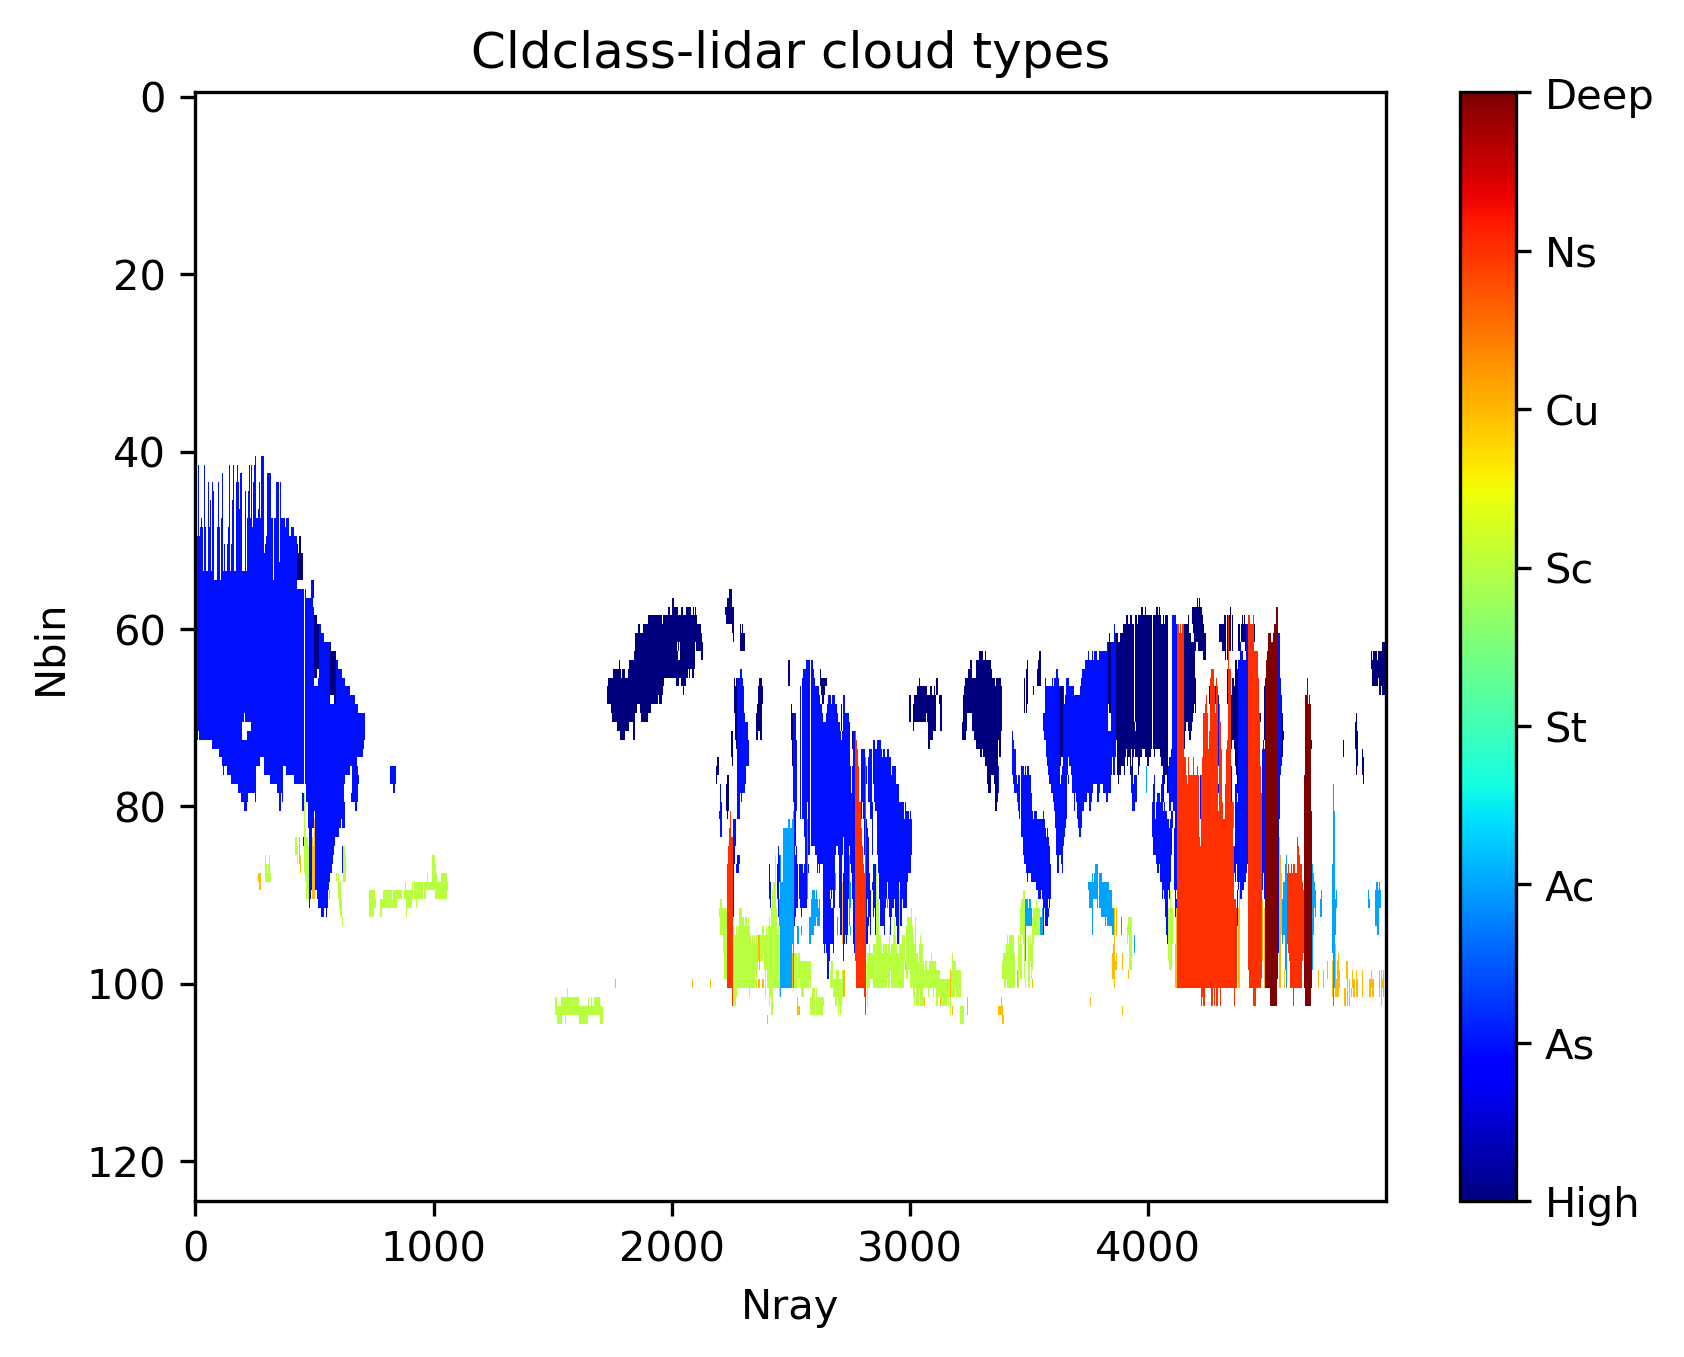

In [8]:
plt.figure(dpi=300)
plt.imshow(
    ma.array(cloud_type_mask.values.T, mask=cloud_type_mask.values.T==0)[:, 10000:15000], 
    aspect="auto", cmap="jet", interpolation="nearest"
)
cbar = plt.colorbar()
cbar.set_ticks(range(1,9))
cbar.set_ticklabels(cloud_type_mask.Flag_values)

plt.title("Cldclass-lidar cloud types")
plt.xlabel("Nray")
plt.ylabel("Nbin")

In [9]:
cwc_ds = open_cloudsat(list(data_path.glob("*2B-CWC-RVOD*.hdf"))[0])

In [10]:
cwc_ds

<xarray.Dataset> Size: 244MB
Dimensions:                          (Nray: 37081, Nbin: 125)
Coordinates:
    DEM_elevation                    (Nray) float32 148kB nan nan ... nan nan
    Height                           (Nray, Nbin) float32 19MB 2.503e+04 ... ...
    Latitude                         (Nray) float32 148kB -0.001594 ... 0.009657
    Longitude                        (Nray) float32 148kB -144.6 ... -169.3
    Pitch_offset                     float64 8B 0.16
    Profile_time                     (Nray) datetime64[ns] 297kB 2010-07-14T1...
    Range_to_intercept               (Nray) float32 148kB 705.5 705.5 ... 705.4
    Roll_offset                      float64 8B 0.0
    TAI_start                        float64 8B 5.533e+08
    UTC_start                        float64 8B 4.1e+04
    Vertical_binsize                 float64 8B 239.8
Dimensions without coordinates: Nray, Nbin
Data variables: (12/26)
    Data_quality                     (Nray) float32 148kB 0.0 0.0 ... 0.0 0.0
    Data_status                      (Nray) float32 148kB 4.148e+03 ... 4.148...
    RayStatus_validity               (Nray) float32 148kB 0.0 0.0 ... 0.0 0.0
    Data_targetID                    (Nray) float32 148kB 0.0 0.0 ... 0.0 0.0
    Navigation_land_sea_flag         (Nray) float32 148kB 2.0 2.0 ... 2.0 2.0
    Liq_Water_Content                (Nray, Nbin) float32 19MB nan nan ... nan
    ...                               ...
    Ice_Water_Path_Uncert            (Nray) float32 148kB nan nan ... nan nan
    Phase                            (Nray, Nbin) float32 19MB 1.0 1.0 ... 0.0
    Radar_Reflectivity_Fwd           (Nray, Nbin) float32 19MB nan nan ... nan
    PIA_Fwd                          (Nray) float32 148kB nan nan ... nan nan
    Error_Flag                       (Nray) float32 148kB 9.0 9.0 ... 9.0 9.0
    Warning_Flag                     (Nray) float32 148kB 0.0 0.0 ... 0.0 0.0
Attributes: (12/13)
    granule_number:     22399.0
    ID_SITE:            Cooperative Institute for Research in the Atmosphere
    ID_CENTER:          CloudSat Data Processing Center
    ID_CENTER_URL:      http://cloudsat.cira.colostate.edu
    ID_CREATED:         Sun Mar 24 18:27:21 2019
    product_version:    P1_R05
    ...                 ...
    algorithm_version:  P1_R05.0
    algorithm_name:     2B-CWC-RVOD
    start_time:         20100714112328
    end_time:           20100714112328
    start_latlon:       [-0.0015936850104480982, -144.5519561767578]
    end_latlon:         [0.009657364338636398, -169.2703399658203]

Text(0, 0.5, 'Nbin')

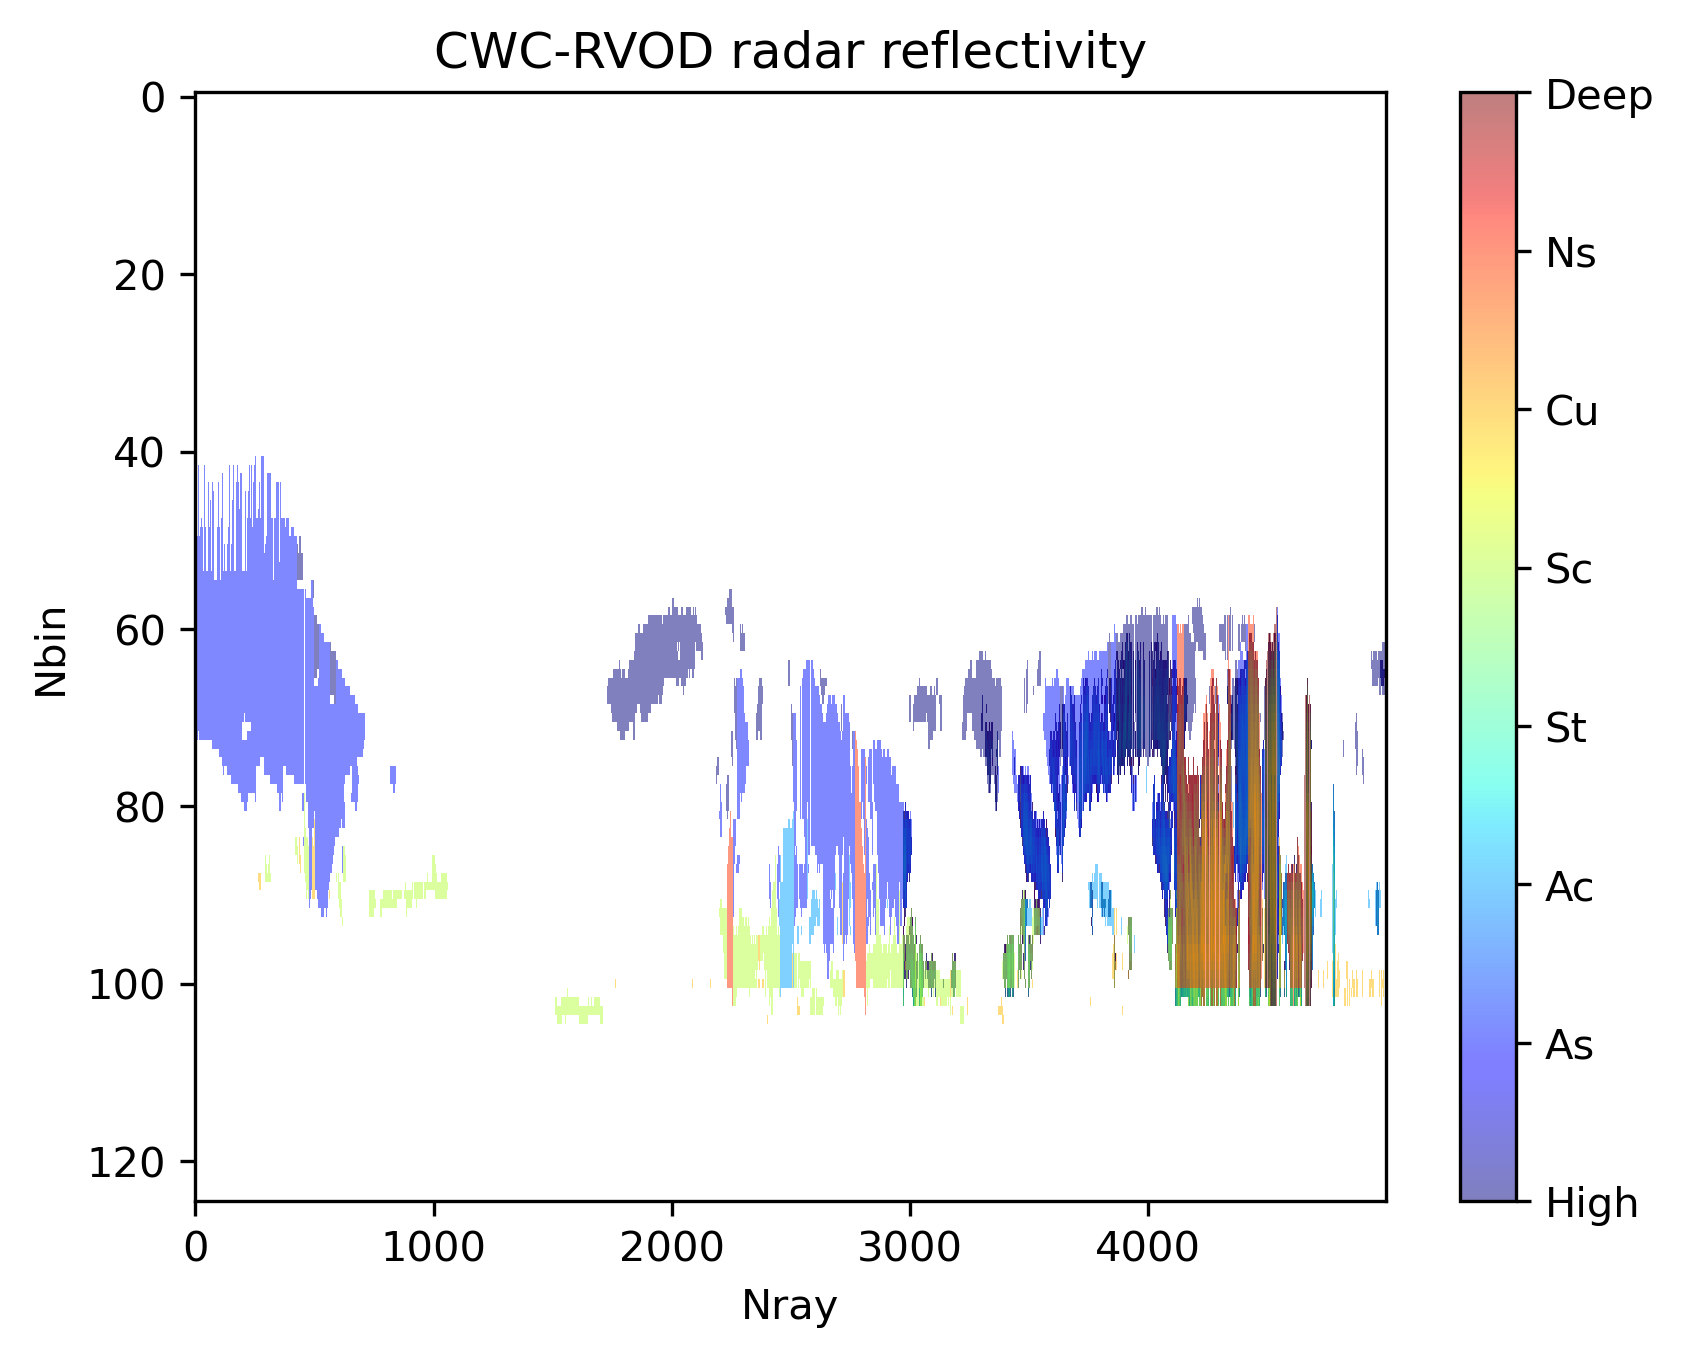

In [11]:
plt.figure(dpi=300)
plt.imshow(
    cwc_ds.Radar_Reflectivity_Fwd.T[:, 10000:15000], aspect="auto", interpolation="nearest"
)
plt.imshow(
    ma.array(cloud_type_mask.values.T, mask=cloud_type_mask.values.T==0)[:, 10000:15000], 
    aspect="auto", cmap="jet", interpolation="nearest", alpha=0.5
)
cbar = plt.colorbar()
cbar.set_ticks(range(1,9))
cbar.set_ticklabels(cloud_type_mask.Flag_values)

plt.title("CWC-RVOD radar reflectivity")
plt.xlabel("Nray")
plt.ylabel("Nbin")

In [12]:
flxhr_ds = open_cloudsat(list(data_path.glob("*2B-FLXHR-LIDAR*.hdf"))[0])

In [13]:
flxhr_ds

<xarray.Dataset> Size: 359MB
Dimensions:                   (Nray: 37081, Nbin: 125, Nbands_Flxhr2B: 2,
                               Nz_Flux_Flxhr2B: 126, Nz_Hr_Flxhr2B: 125,
                               Nflags: 20, Nlatbins: 8)
Coordinates:
    Profile_time              (Nray) datetime64[ns] 297kB 2010-07-14T11:23:21...
    UTC_start                 float64 8B 4.1e+04
    TAI_start                 float64 8B 5.533e+08
    Latitude                  (Nray) float32 148kB -0.001594 ... 0.009657
    Longitude                 (Nray) float32 148kB -144.6 -144.6 ... -169.3
    Height                    (Nray, Nbin) float32 19MB 2.503e+04 ... -4.804e+03
    Range_to_intercept        (Nray) float32 148kB 705.5 705.5 ... 705.4 705.4
    DEM_elevation             (Nray) float32 148kB nan nan nan ... nan nan nan
    Vertical_binsize          float64 8B 239.8
    Pitch_offset              float64 8B 0.16
    Roll_offset               float64 8B 0.0
    SurfaceHeightBin          (Nray) float32 148kB 105.0 105.0 ... 105.0 105.0
Dimensions without coordinates: Nray, Nbin, Nbands_Flxhr2B, Nz_Flux_Flxhr2B,
                                Nz_Hr_Flxhr2B, Nflags, Nlatbins
Data variables: (12/46)
    Data_quality              (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Data_status               (Nray) float32 148kB 4.148e+03 ... 4.148e+03
    Data_targetID             (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RayStatus_validity        (Nray) float32 148kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Navigation_land_sea_flag  (Nray) float32 148kB 2.0 2.0 2.0 ... 2.0 2.0 2.0
    FD                        (Nbands_Flxhr2B, Nray, Nz_Flux_Flxhr2B) float32 37MB ...
    ...                        ...
    MeanQSW                   (Nflags, Nlatbins) float32 640B 0.74 0.74 ... nan
    SigmaQSW                  (Nflags, Nlatbins) float32 640B 0.74 0.4 ... nan
    Solar_zenith_angle        (Nray) float32 148kB 147.7 147.7 ... 147.7 147.7
    Land_Char                 (Nray) float32 148kB 17.0 17.0 17.0 ... 17.0 17.0
    Albedo                    (Nray) float32 148kB 0.2476 0.2476 ... 0.2476
    FlagCounts                (Nflags) float64 160B 1.192e+04 7.116e+03 ... 0.0
Attributes:
    granule_number:     22399.0
    ID_SITE:            Cooperative Institute for Research in the Atmosphere
    ID_CENTER:          CloudSat Data Processing Center
    ID_CENTER_URL:      http://cloudsat.cira.colostate.edu
    ID_MACHINE:         CSATLAS3
    ID_CREATED:         Thu Jan 05 20:33:48 2023
    algorithm_name:     2B-FLXHR-LIDAR
    algorithm_version:  P2_R05.2
    product_version:    P2_R05
    start_time:         20100714112321
    end_time:           20100714130213

Text(0, 0.5, 'Nbin')

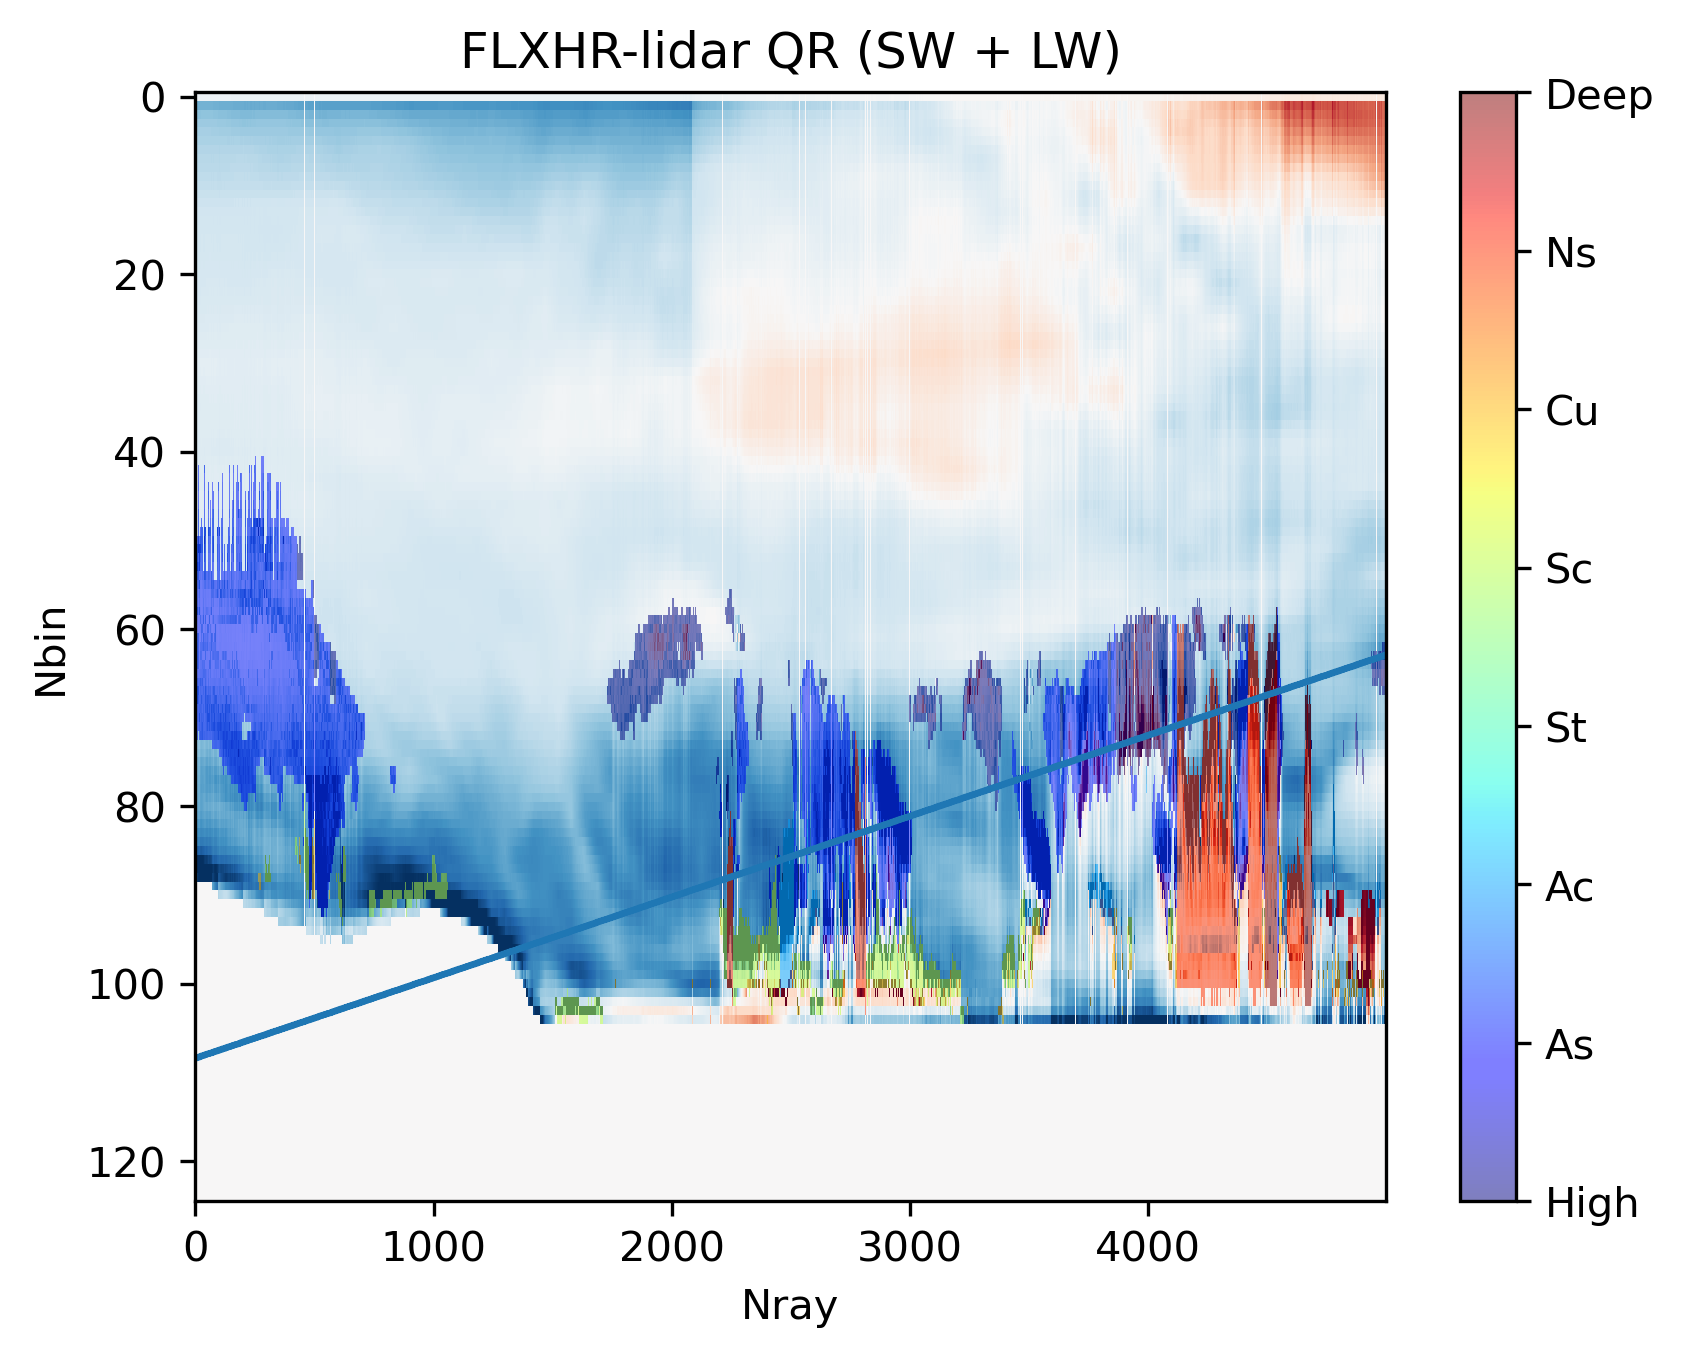

In [14]:
plt.figure(dpi=300)
plt.imshow(
    flxhr_ds.QR.sum("Nbands_Flxhr2B").T[:, 10000:15000], aspect="auto", interpolation="nearest", cmap="RdBu_r", vmin=-2, vmax=2
)
plt.imshow(
    ma.array(cloud_type_mask.values.T, mask=cloud_type_mask.values.T==0)[:, 10000:15000], 
    aspect="auto", cmap="jet", interpolation="nearest", alpha=0.5
)
cbar = plt.colorbar()
cbar.set_ticks(range(1,9))
cbar.set_ticklabels(cloud_type_mask.Flag_values)

plt.plot(flxhr_ds.Solar_zenith_angle[10000:15000])

plt.title("FLXHR-lidar QR (SW + LW)")
plt.xlabel("Nray")
plt.ylabel("Nbin")